In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

DATASET_COLUMNS  = ["Sentiment", "Id", "Date", "Flag", "User", "Text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)


df['Sentiment'] = df['Sentiment'].replace({0: 0, 4: 1})


df_class_0 = df[df['Sentiment'] == 0].sample(frac=0.1, random_state=42)
df_class_1 = df[df['Sentiment'] == 1].sample(frac=0.1, random_state=42)


df_sampled = pd.concat([df_class_0, df_class_1])


df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)


print("Class '0':", len(df_class_0), "occurrences")
print("Class '1':", len(df_class_1), "occurrences")
print(df_sampled.head())

Class '0': 80000 occurrences
Class '1': 80000 occurrences
   Sentiment          Id                          Date      Flag  \
0          1  2177180859  Mon Jun 15 05:36:58 PDT 2009  NO_QUERY   
1          0  1691852524  Sun May 03 18:44:52 PDT 2009  NO_QUERY   
2          0  2264405416  Sun Jun 21 03:46:09 PDT 2009  NO_QUERY   
3          0  1968446991  Fri May 29 21:27:23 PDT 2009  NO_QUERY   
4          1  1983155699  Sun May 31 12:36:42 PDT 2009  NO_QUERY   

              User                                               Text  
0          Jaanuli                                  it's my birthday   
1  bernadetteolsen  @StaciG She sent home the best guy, I'm over t...  
2          Ginyera  And sore throat again...damn it!  And where th...  
3       uniquenezz  WATCHING JAY LENO   Time flies...17 years!!!! ...  
4       nscrwriter  @SooBoatWatcher If you are ever so inclined, I...  


In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Remove unnecessary columns
df_sampled = df_sampled[['Sentiment', 'Text']]


def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove @ and # characters
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)


df_sampled['Text'] = df_sampled['Text'].apply(preprocess_text)


print(df_sampled.head())


## Tokenize and Pad the Text Data

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


vocab_size = 10000  
max_length = 100 
trunc_type = 'post'  
padding_type = 'post'  


tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df_sampled['Text'])


sequences = tokenizer.texts_to_sequences(df_sampled['Text'])


padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


print("Shape of padded sequences:", padded_sequences.shape)

labels = df_sampled['Sentiment'].values


Shape of padded sequences: (160000, 100)


## Split the Data into Training and Testing Sets

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (128000, 100) (128000,)
Testing set shape: (32000, 100) (32000,)


## Building an LSTM Model with an Attention Mechanism

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


###  Define the Attention Layer

In [15]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="random_normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)


### Define and Compile the Model

In [18]:
def create_model(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    attention = Attention()(lstm)
    dense1 = Dense(64, activation='relu')(attention)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


vocab_size = 10000
embedding_dim = 100
max_length = 100


model = create_model(vocab_size, embedding_dim, max_length)
model.summary()


C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,109,313 (4.23 MB)

 Trainable params: 1,109,313 (4.23 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 165s 161ms/step - accuracy: 0.5627 - loss: 0.6622 - val_accuracy: 0.7616 - val_loss: 0.4998
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 187s 187ms/step - accuracy: 0.7796 - loss: 0.4747 - val_accuracy: 0.7640 - val_loss: 0.4870
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 177s 177ms/step - accuracy: 0.7967 - loss: 0.4392 - val_accuracy: 0.7629 - val_loss: 0.4980
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 180s 180ms/step - accuracy: 0.8139 - loss: 0.4035 - val_accuracy: 0.7593 - val_loss: 0.5182
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 225s 225ms/step - accuracy: 0.8304 - loss: 0.3668 - val_accuracy: 0.7557 - val_loss: 0.5575
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 223s 223ms/step - accuracy: 0.8461 - loss: 0.3332 - val_accuracy: 0.7488 - val_loss: 0.6264
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 216s 216ms/step - accuracy: 0.8610 - loss: 0.3017 - val_accuracy: 0.7444 - val_loss: 0.7153
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 233s 233ms/step - ac

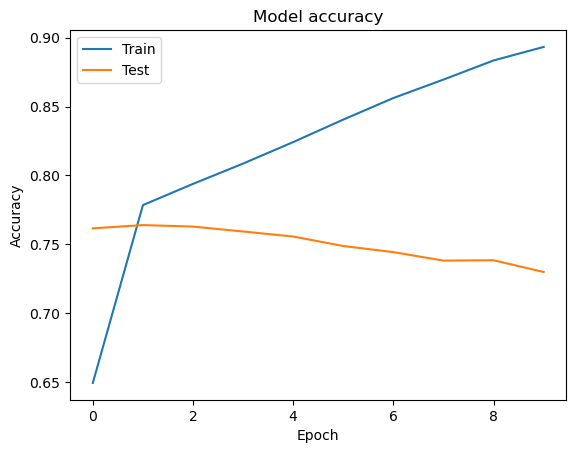

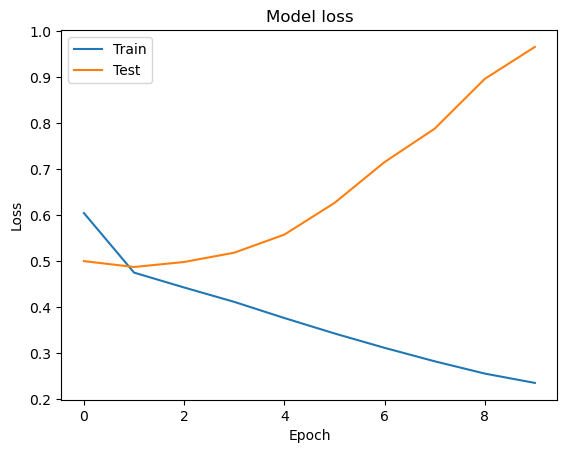

In [21]:

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=128)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Implementing Regularization and Early Stopping

C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 261s 257ms/step - accuracy: 0.5013 - loss: 1.2773 - val_accuracy: 0.4988 - val_loss: 0.6932
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 239s 239ms/step - accuracy: 0.5012 - loss: 0.6932 - val_accuracy: 0.5012 - val_loss: 0.6932
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 258s 258ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.5012 - val_loss: 0.6931
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 283s 283ms/step - accuracy: 0.4988 - loss: 0.6932 - val_accuracy: 0.5012 - val_loss: 0.6931
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 289s 289ms/step - accuracy: 0.5007 - loss: 0.6932 - val_accuracy: 0.4988 - val_loss: 0.6932
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 293s 293ms/step - accuracy: 0.5020 - loss: 0.6932 - val_accuracy: 0.4988 - val_loss: 0.6932


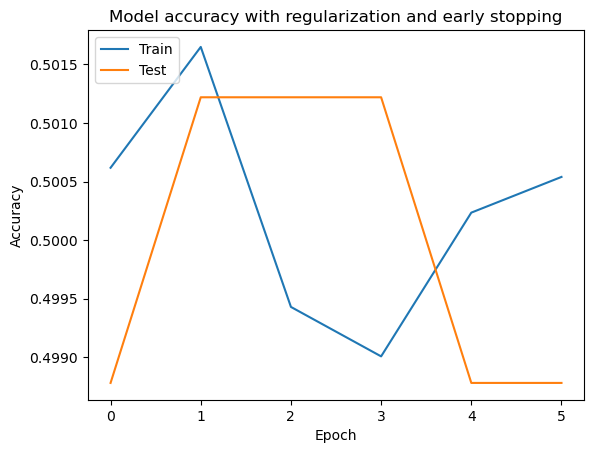

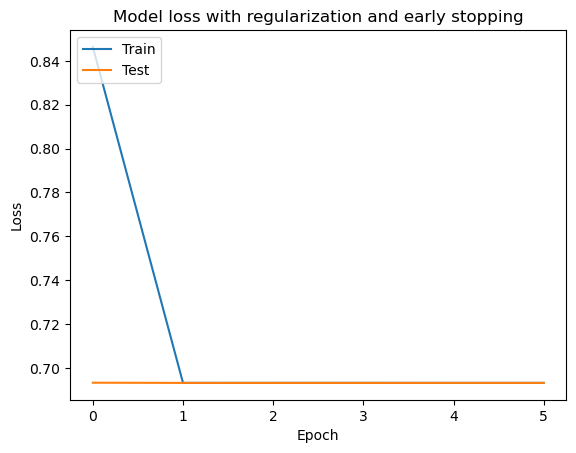

In [23]:
from tensorflow.keras.callbacks import EarlyStopping


def create_model_with_regularization(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)))(embedding)
    attention = Attention()(lstm)
    dense1 = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(attention)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


model_with_reg = create_model_with_regularization(vocab_size, embedding_dim, max_length)


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history_with_reg = model_with_reg.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=128, callbacks=[early_stopping])


plt.plot(history_with_reg.history['accuracy'])
plt.plot(history_with_reg.history['val_accuracy'])
plt.title('Model accuracy with regularization and early stopping')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history_with_reg.history['loss'])
plt.plot(history_with_reg.history['val_loss'])
plt.title('Model loss with regularization and early stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Steps to Diagnose and Improve the Model
- Experiment with Learning Rates: Try different learning rates to see if the model's performance improves.
- Simplify the Model: Start with a simpler model (e.g., a basic LSTM without attention) to see if it can learn anything from the data.
- Check Data Preprocessing: Ensure the data preprocessing steps (like tokenization and padding) are correct and consistent.
- Increase Training Data: Use a larger subset of your data to see if the model's performance improves.

### Adjusting Learning Rate and Simplifying Model

Epoch 1/20


C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 221s 219ms/step - accuracy: 0.5052 - loss: 0.6929 - val_accuracy: 0.7183 - val_loss: 0.5785
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 245s 202ms/step - accuracy: 0.7381 - loss: 0.5490 - val_accuracy: 0.7549 - val_loss: 0.5108
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 211s 211ms/step - accuracy: 0.7685 - loss: 0.4930 - val_accuracy: 0.7591 - val_loss: 0.5028
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 211s 211ms/step - accuracy: 0.7825 - loss: 0.4720 - val_accuracy: 0.7407 - val_loss: 0.5108
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 216s 216ms/step - accuracy: 0.7891 - loss: 0.4605 - val_accuracy: 0.7627 - val_loss: 0.4933
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 256s 256ms/step - accuracy: 0.7936 - loss: 0.4539 - val_accuracy: 0.7513 - val_loss: 0.5049
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 257s 257ms/step - accuracy: 0.7929 - loss: 0.4529 - val_accuracy: 0.7622 - val_loss: 0.4956
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 229s 229ms/step - accuracy: 0.7

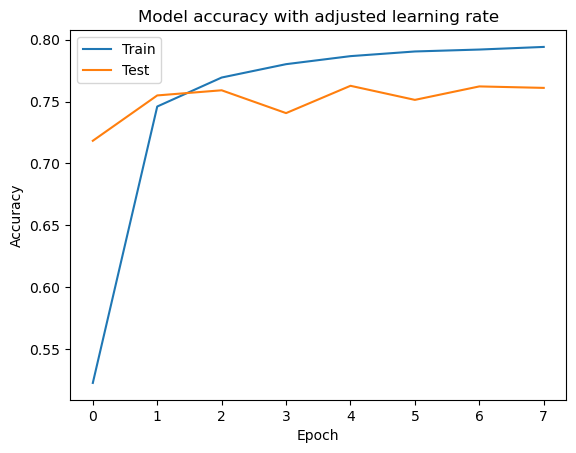

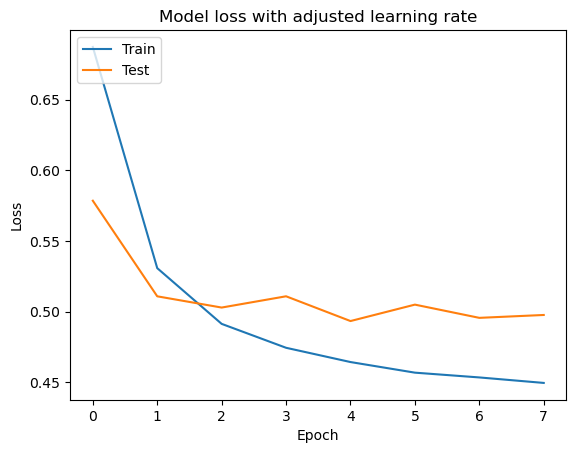

In [28]:
from tensorflow.keras.optimizers import Adam


learning_rate = 0.0001  # Lower learning rate
optimizer = Adam(learning_rate=learning_rate)

def create_model_adjusted_lr(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    attention = Attention()(lstm)
    dense1 = Dense(64, activation='relu')(attention)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


model_adjusted_lr = create_model_adjusted_lr(vocab_size, embedding_dim, max_length)


history_adjusted_lr = model_adjusted_lr.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=128, callbacks=[early_stopping])


plt.plot(history_adjusted_lr.history['accuracy'])
plt.plot(history_adjusted_lr.history['val_accuracy'])
plt.title('Model accuracy with adjusted learning rate')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history_adjusted_lr.history['loss'])
plt.plot(history_adjusted_lr.history['val_loss'])
plt.title('Model loss with adjusted learning rate')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Simplify the Model

Epoch 1/20


C:\Users\ayadav\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 193s 190ms/step - accuracy: 0.6941 - loss: 0.5660 - val_accuracy: 0.7637 - val_loss: 0.4850
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 187s 187ms/step - accuracy: 0.7873 - loss: 0.4521 - val_accuracy: 0.7663 - val_loss: 0.4877
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 187s 187ms/step - accuracy: 0.8057 - loss: 0.4126 - val_accuracy: 0.7637 - val_loss: 0.5081
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 207s 207ms/step - accuracy: 0.8235 - loss: 0.3758 - val_accuracy: 0.7592 - val_loss: 0.5561


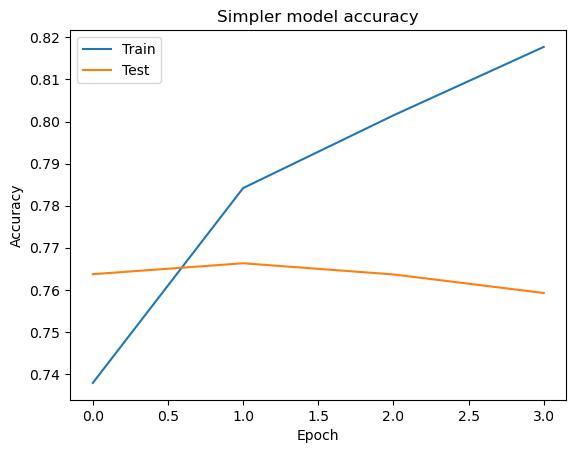

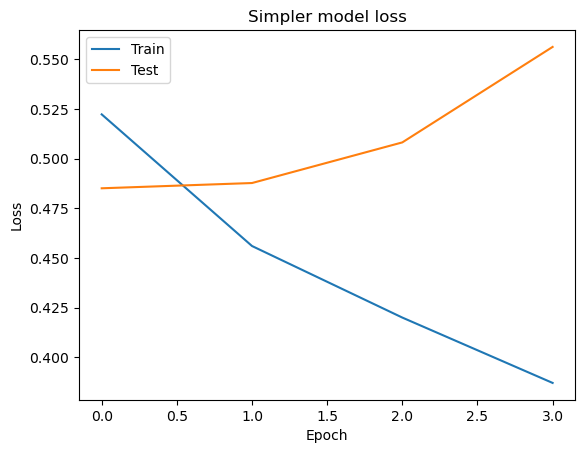

In [30]:

def create_simpler_model(vocab_size, embedding_dim, max_length):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(64))(embedding)
    dense1 = Dense(64, activation='relu')(lstm)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


simpler_model = create_simpler_model(vocab_size, embedding_dim, max_length)


history_simpler_model = simpler_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=128, callbacks=[early_stopping])


plt.plot(history_simpler_model.history['accuracy'])
plt.plot(history_simpler_model.history['val_accuracy'])
plt.title('Simpler model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history_simpler_model.history['loss'])
plt.plot(history_simpler_model.history['val_loss'])
plt.title('Simpler model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
